<a href="https://colab.research.google.com/github/sejalraikwa/quantium-data-insights/blob/main/Task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, ttest_ind
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("QVI_data.csv")

In [3]:
df['DATE'] = pd.to_datetime(df['DATE'])
df['MONTH'] = df['DATE'].dt.to_period('M')

# Monthly Metrics

In [4]:
monthly_metrics = (
    df.groupby(['STORE_NBR', 'MONTH'])
    .agg(
        total_sales=('TOT_SALES', 'sum'),
        total_customers=('LYLTY_CARD_NBR', 'nunique'),
        transactions=('TXN_ID', 'nunique')
    )
    .reset_index()
)

monthly_metrics['avg_txn_per_customer'] = (
    monthly_metrics['transactions'] / monthly_metrics['total_customers']
)

monthly_metrics.head()

,STORE_NBR,MONTH,total_sales,total_customers,transactions,avg_txn_per_customer
0,1,2018-07,206.9,49,52,1.061224
1,1,2018-08,176.1,42,43,1.023810
2,1,2018-09,278.8,59,62,1.050847
3,1,2018-10,188.1,44,45,1.022727
4,1,2018-11,192.6,46,47,1.021739


In [5]:
trial_stores = [77, 86, 88]

pre_trial = monthly_metrics[monthly_metrics['MONTH'] < '2019-02']
trial_period = monthly_metrics[monthly_metrics['MONTH'] >= '2019-02']

In [6]:
def find_control_store(trial_store, metric='total_sales'):

    trial_data = pre_trial[
        pre_trial['STORE_NBR'] == trial_store
    ][metric].values

    correlations = {}

    for store in pre_trial['STORE_NBR'].unique():
        if store == trial_store:
            continue

        control_data = pre_trial[
            pre_trial['STORE_NBR'] == store
        ][metric].values

        if len(control_data) == len(trial_data):
            corr, _ = pearsonr(trial_data, control_data)
            correlations[store] = corr

    best_control = max(correlations, key=correlations.get)
    return best_control

In [7]:
control_pairs = {
    trial: find_control_store(trial)
    for trial in trial_stores
}

control_pairs

{77: np.int64(71), 86: np.int64(155), 88: np.int64(159)}

# Statistical Test (Trial vs Control)

In [8]:
results = []

for trial, control in control_pairs.items():

    trial_sales = trial_period[
        trial_period['STORE_NBR'] == trial
    ]['total_sales']

    control_sales = trial_period[
        trial_period['STORE_NBR'] == control
    ]['total_sales']

    t_stat, p_val = ttest_ind(
        trial_sales, control_sales, equal_var=False
    )

    results.append({
        'Trial Store': trial,
        'Control Store': control,
        'Mean Trial Sales': trial_sales.mean(),
        'Mean Control Sales': control_sales.mean(),
        'p-value': p_val
    })

results_df = pd.DataFrame(results)
results_df

,Trial Store,Control Store,Mean Trial Sales,Mean Control Sales,p-value
0,77,71,268.20,984.86,8.760745e-06
1,86,155,903.10,864.05,3.567116e-01
2,88,159,1389.93,32.70,6.314406e-07


# Customers vs Transactions

In [9]:
driver_results = []

for trial, control in control_pairs.items():

    trial_data = trial_period[
        trial_period['STORE_NBR'] == trial
    ]

    control_data = trial_period[
        trial_period['STORE_NBR'] == control
    ]

    driver_results.append({
        'Trial Store': trial,
        'Customer Change': trial_data['total_customers'].mean()
                            - control_data['total_customers'].mean(),

        'Avg Txn/Customer Change': trial_data['avg_txn_per_customer'].mean()
                                    - control_data['avg_txn_per_customer'].mean()
    })

driver_df = pd.DataFrame(driver_results)
driver_df

,Trial Store,Customer Change,Avg Txn/Customer Change
0,77,-64.6,-0.229856
1,86,8.0,-0.039594
2,88,120.8,0.237391


# Visualization

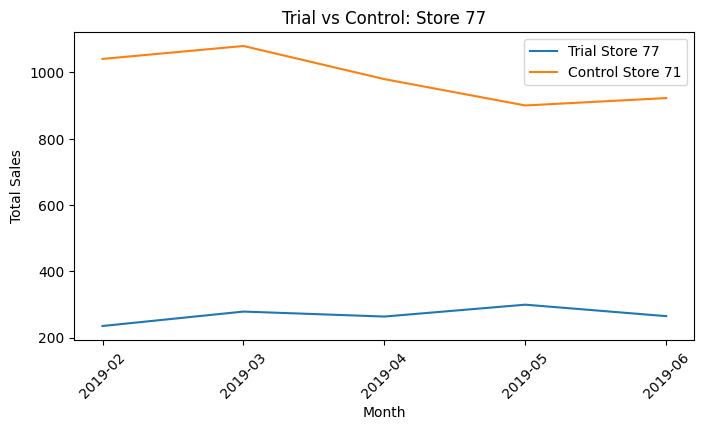

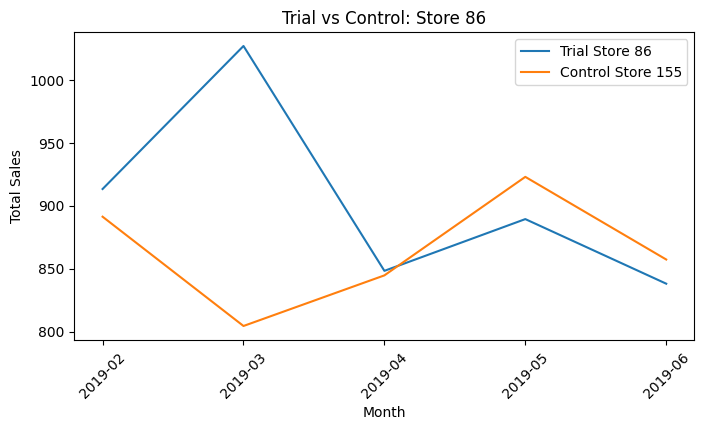

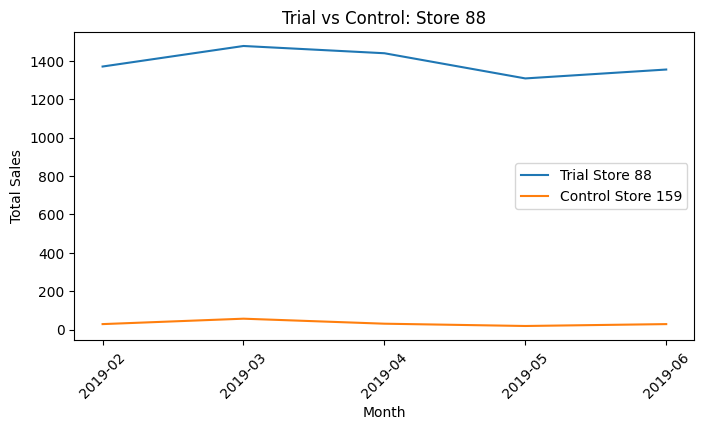

In [10]:
for trial, control in control_pairs.items():

    plt.figure(figsize=(8,4))

    plt.plot(
        trial_period[trial_period['STORE_NBR'] == trial]['MONTH'].astype(str),
        trial_period[trial_period['STORE_NBR'] == trial]['total_sales'],
        label=f'Trial Store {trial}'
    )

    plt.plot(
        trial_period[trial_period['STORE_NBR'] == control]['MONTH'].astype(str),
        trial_period[trial_period['STORE_NBR'] == control]['total_sales'],
        label=f'Control Store {control}'
    )

    plt.xticks(rotation=45)
    plt.title(f"Trial vs Control: Store {trial}")
    plt.xlabel("Month")
    plt.ylabel("Total Sales")
    plt.legend()
    plt.show()